In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from sklearn.manifold import TSNE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
%matplotlib inline
# %matplotlib notebook
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
# 디렉토리 설정
unlabeled_data_dir = r"./injectionmoding_dataset/injectionmoding_dataset_unlabeled.csv"
unlabeled_init_df = pd.read_csv(unlabeled_data_dir)

labeled_data_dir = r"./injectionmoding_dataset/경진대회용 사출성형기 데이터셋_labeled.csv"
labeled_init_df = pd.read_csv(labeled_data_dir)

In [3]:
# 디스플레이 옵션 설정
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.unicode.east_asian_width', True)

In [4]:
def useless_data_drop(dataframe):
    # 중복 데이터 제거
    dataframe = dataframe.drop_duplicates()
    # 1차 분석 후 불필요 데이터 제거
    dataframe.drop("_id", axis=1, inplace=True)
    dataframe.drop("PART_FACT_PLAN_DATE", axis=1, inplace=True)
    # 분석모델에 쓸모 없는 데이터 제거
    for column, value in dataframe.std().iteritems():
        if value == 0:
            dataframe.drop(f"{column}", axis=1, inplace=True)
    # Datetime으로 변경
    dataframe["TimeStamp"] = pd.to_datetime(dataframe['TimeStamp'], yearfirst=True)
    return dataframe

In [5]:
# 필요없는 데이터 제거
useless_drop_unlabeled_df = useless_data_drop(unlabeled_init_df)
useless_drop_unlabeled_df.drop("Unnamed: 0", axis=1, inplace=True)

useless_drop_labeled_df = useless_data_drop(labeled_init_df)

C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [6]:
# 장비, 제품 별 분류 함수
def div_pa_eq(dataframe, part_name, equip_name):
    part_name_filter = dataframe["PART_NAME"].str.contains(part_name)
    equip_name_filter = dataframe["EQUIP_NAME"].str.contains(equip_name)

    return dataframe[part_name_filter & equip_name_filter]

In [7]:
# CN7_우진650톤 데이터 추출
CN7_filter = useless_drop_unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = useless_drop_unlabeled_df["EQUIP_NAME"].str.contains("650")
ERR_filter = useless_drop_unlabeled_df["ERR_FACT_QTY"] <= 5  # 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
SOP_filter = useless_drop_unlabeled_df["Switch_Over_Position"] == 0  # Switch_Over_Position 0인지 아닌지에 따라 공정이 달라지는듯

Unlabeled_CN7_650T_df = useless_drop_unlabeled_df[CN7_filter & Eq650_filter & ERR_filter & SOP_filter]

In [8]:
# 이상치 측정 함수
def outlier(x):
    Q1 = x.quantile(1/4)
    Q3 = x.quantile(3/4)
    IQR = Q3 - Q1
    LL = Q1 - (1.5*IQR)
    UU = Q3 + (1.5*IQR)
    outlier = (x < LL) | (x > UU)
    return outlier

# unlabeled데이터 분석 후 사용 안하는 데이터 제거

C:\Users\break\anaconda3\envs\keras\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\break\anaconda3\envs\keras\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50864 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\break\anaconda3\envs\keras\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\break\anaconda3\envs\keras\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\break\anaconda3\envs\keras\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\break\anaconda3\envs\keras\lib\site-packages\matplotlib\backe

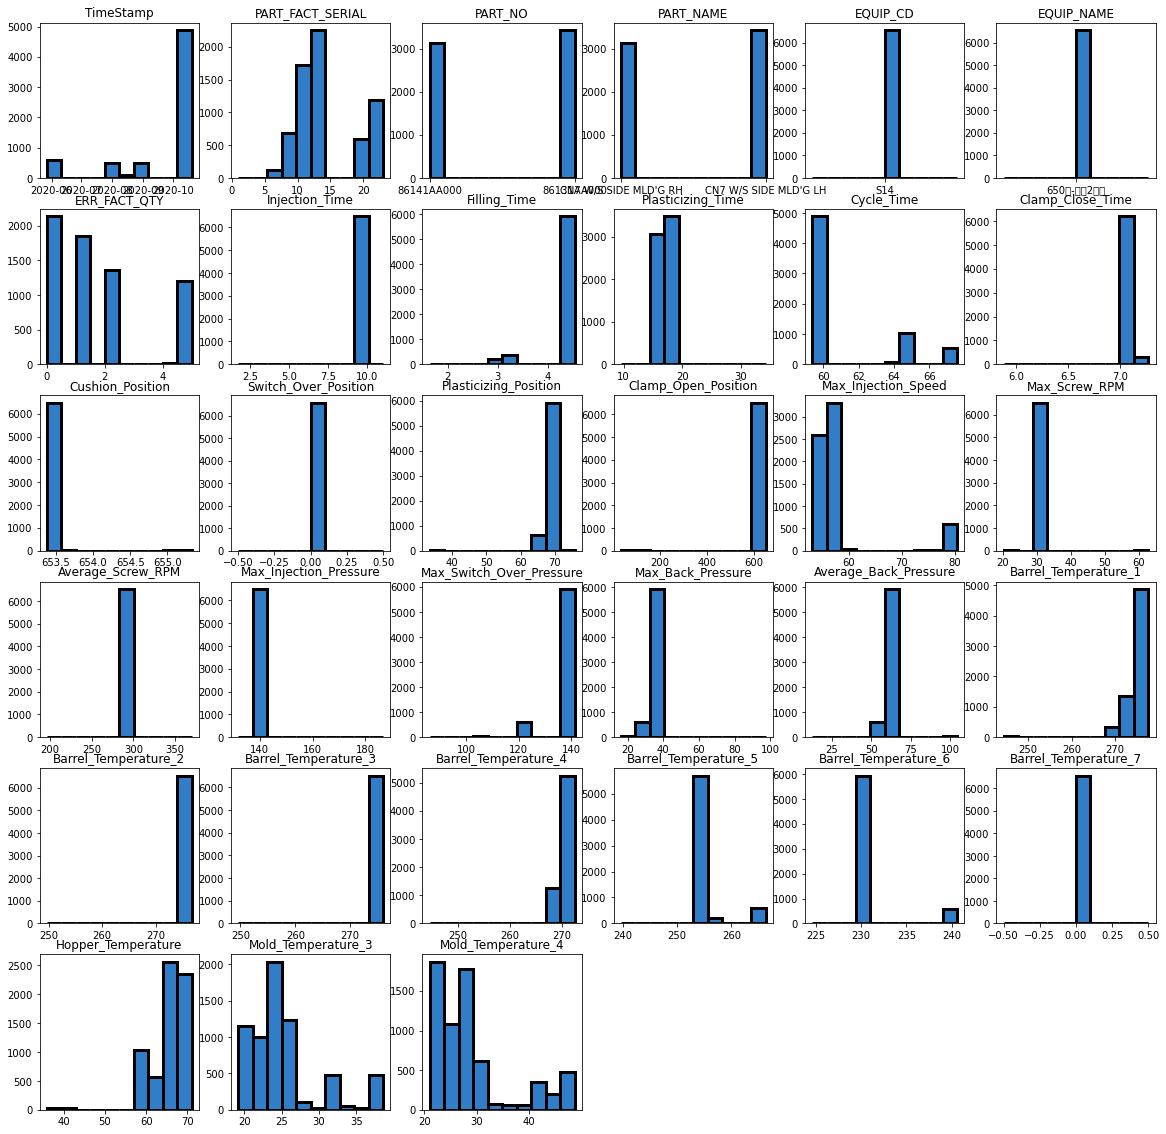

In [9]:
data = Unlabeled_CN7_650T_df
for index, value in enumerate(data):
    sub = plt.subplot(6, 6, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

# labeled데이터 분석 후 사용 안하는 데이터 제거

In [11]:
# CN7_우진650톤 데이터 추출
CN7_filter = useless_drop_labeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = useless_drop_labeled_df["EQUIP_NAME"].str.contains("650")

labeled_CN7_650T = useless_drop_labeled_df[CN7_filter & Eq650_filter]

# # Pass or Fail, Reason 데이터를 더미 변수로 변환
# label_encoder = preprocessing.LabelEncoder()
# onehot_encoder = preprocessing.OneHotEncoder()
# onehot_Reason = label_encoder.fit_transform(labeled_df["Reason"])
# labeled_df["Reason"] = onehot_Reason

# 데이터 분석 후 종속 변수 제거
labeled_CN7_650T["Packing_Time"] = labeled_CN7_650T["Injection_Time"] - labeled_CN7_650T["Filling_Time"]
labeled_CN7_650T["Avg_Mold_Temperature"] = (labeled_CN7_650T["Mold_Temperature_3"] + labeled_CN7_650T["Mold_Temperature_4"])/2
Labeled_CN7_650T_train = labeled_CN7_650T.drop(["PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "Average_Back_Pressure", "Clamp_Open_Position", "Average_Screw_RPM", "TimeStamp","Injection_Time", "Switch_Over_Position", "Mold_Temperature_3", "Mold_Temperature_4","Barrel_Temperature_7" ], axis=1)
# Labeled_CN7_650T_train = labeled_CN7_650T.drop(["Average_Screw_RPM", "Packing_Time", "PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)
# Labeled_CN7_650T_train = Labeled_CN7_650T_train.drop(["Clamp_Open_Position", "Average_Screw_RPM", "Packing_Time"], axis=1)

# PassFail 분류
Labeled_CN7_650T_train_Y = Labeled_CN7_650T_train[Labeled_CN7_650T_train["PassOrFail"].str.contains("Y")]
Labeled_CN7_650T_train_N = Labeled_CN7_650T_train[Labeled_CN7_650T_train["PassOrFail"].str.contains("N")]
Labeled_CN7_650T_train_Y.drop(["PassOrFail", "Reason"], axis=1, inplace=True)
Labeled_df_N_test = Labeled_CN7_650T_train_N.drop(["PassOrFail","Reason"], axis=1)

Labeled_CN7_650T_train_Y.info()
Labeled_CN7_650T_train_N["Reason"].value_counts()

C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 0 to 5157
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              3946 non-null   float64
 1   Plasticizing_Time         3946 non-null   float64
 2   Clamp_Close_Time          3946 non-null   float64
 3   Cushion_Position          3946 non-null   float64
 4   Plasticizing_Position     3946 non-null   float64
 5   Max_Injection_Speed       3946 non-null   float64
 6   Max_Screw_RPM             3946 non-null   float64
 7   Max_Injection_Pressure    3946 non-null   float64
 8   Max_Switch_Over_Pressure  3946 non-null   float64
 9   Max_Back_Pressure         3946 non-null   float64
 10  Barrel_Temperature_1      3946 non-null   float64
 11  Barrel_Temperature_2      3946 non-null   float64
 12  Barrel_Temperature_3      3946 non-null   float64
 13  Barrel_Temperature_4      3946 non-null   float64
 14  Barrel_T

가스            13
초기허용불량    10
미성형           5
Name: Reason, dtype: int64

# 각 데이터 히스토그램 시각화

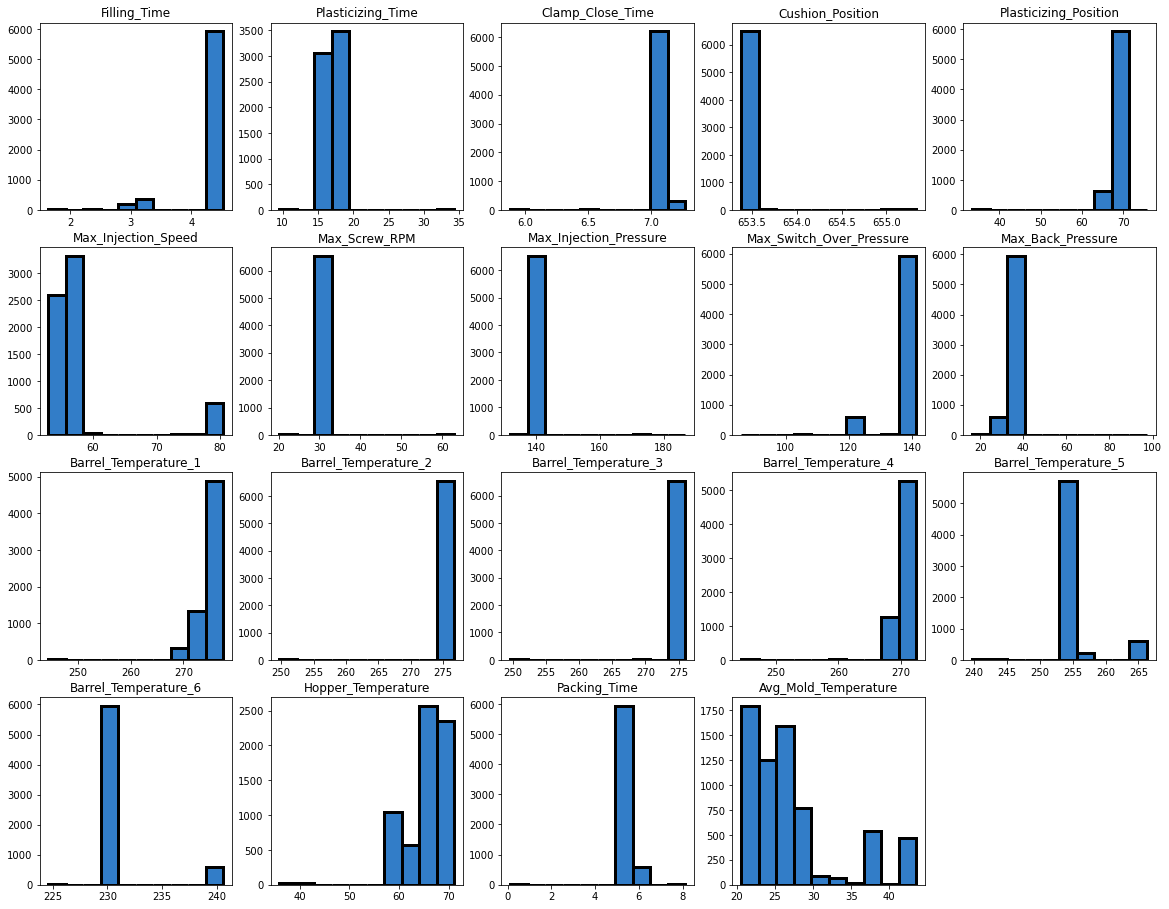

In [12]:
# unlabele데이터 히스토그램 시각화

data = Unlabeled_CN7_650T_train
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

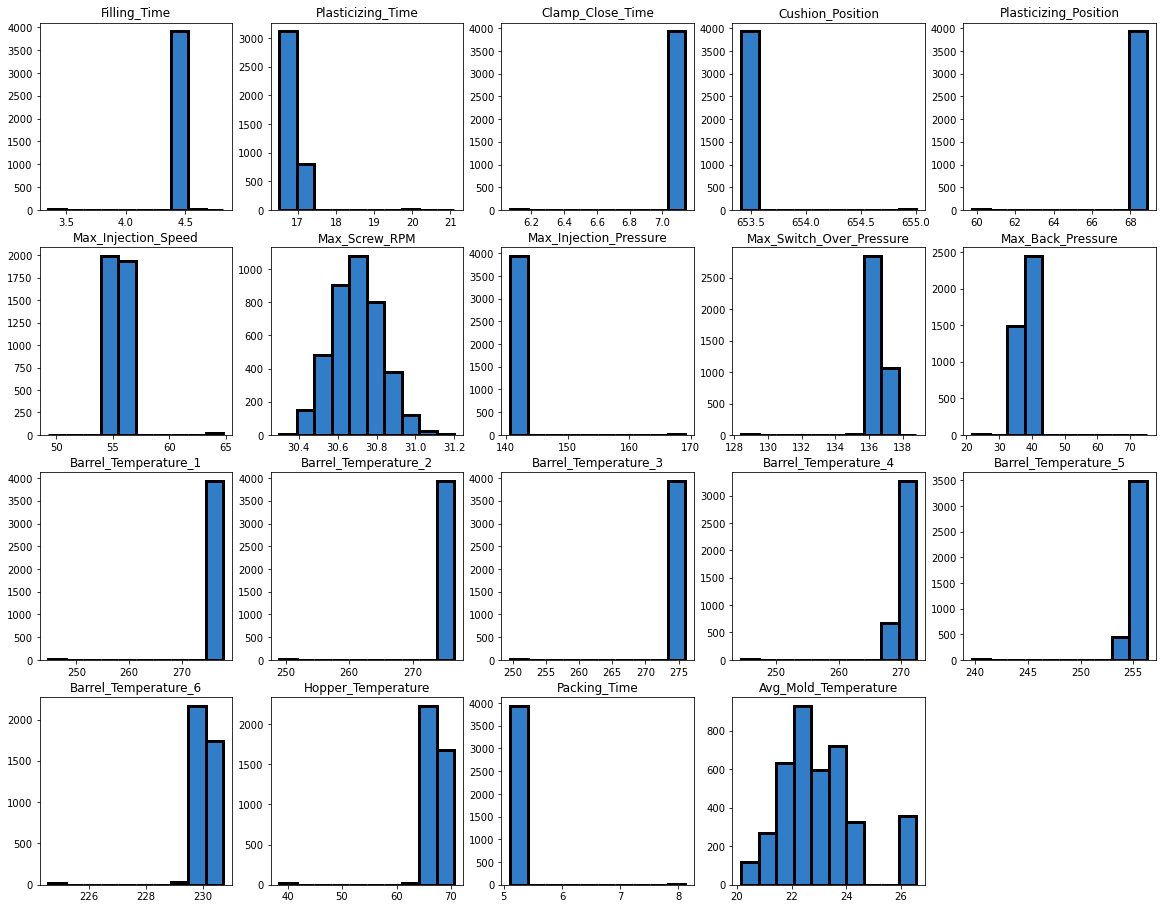

In [13]:
# labele데이터 히스토그램 시각화

data = Labeled_CN7_650T_train_Y
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

# DAE 적용

In [130]:
# label+unlabeled train 데이터
Train_DF = pd.concat([Unlabeled_CN7_650T_train, Labeled_CN7_650T_train_Y], ignore_index=True)
Train_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10518 entries, 0 to 10517
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              10518 non-null  float64
 1   Plasticizing_Time         10518 non-null  float64
 2   Clamp_Close_Time          10518 non-null  float64
 3   Cushion_Position          10518 non-null  float64
 4   Plasticizing_Position     10518 non-null  float64
 5   Max_Injection_Speed       10518 non-null  float64
 6   Max_Screw_RPM             10518 non-null  float64
 7   Max_Injection_Pressure    10518 non-null  float64
 8   Max_Switch_Over_Pressure  10518 non-null  float64
 9   Max_Back_Pressure         10518 non-null  float64
 10  Barrel_Temperature_1      10518 non-null  float64
 11  Barrel_Temperature_2      10518 non-null  float64
 12  Barrel_Temperature_3      10518 non-null  float64
 13  Barrel_Temperature_4      10518 non-null  float64
 14  Barrel

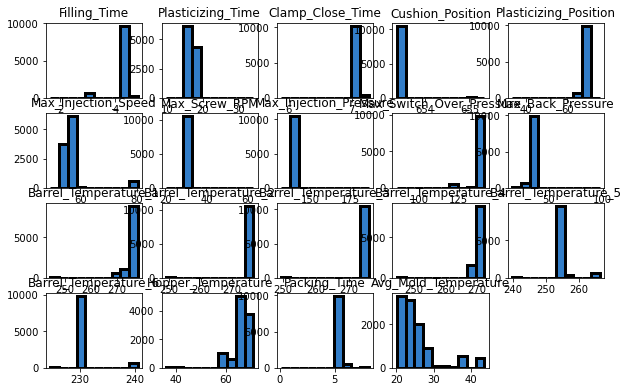

In [131]:
# train 데이터 히스토그램 시각화

data = Train_DF
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

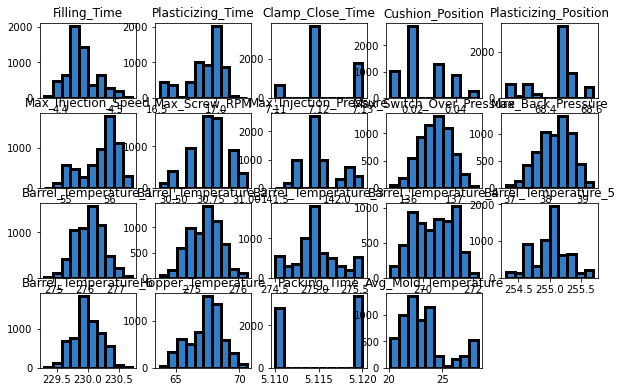

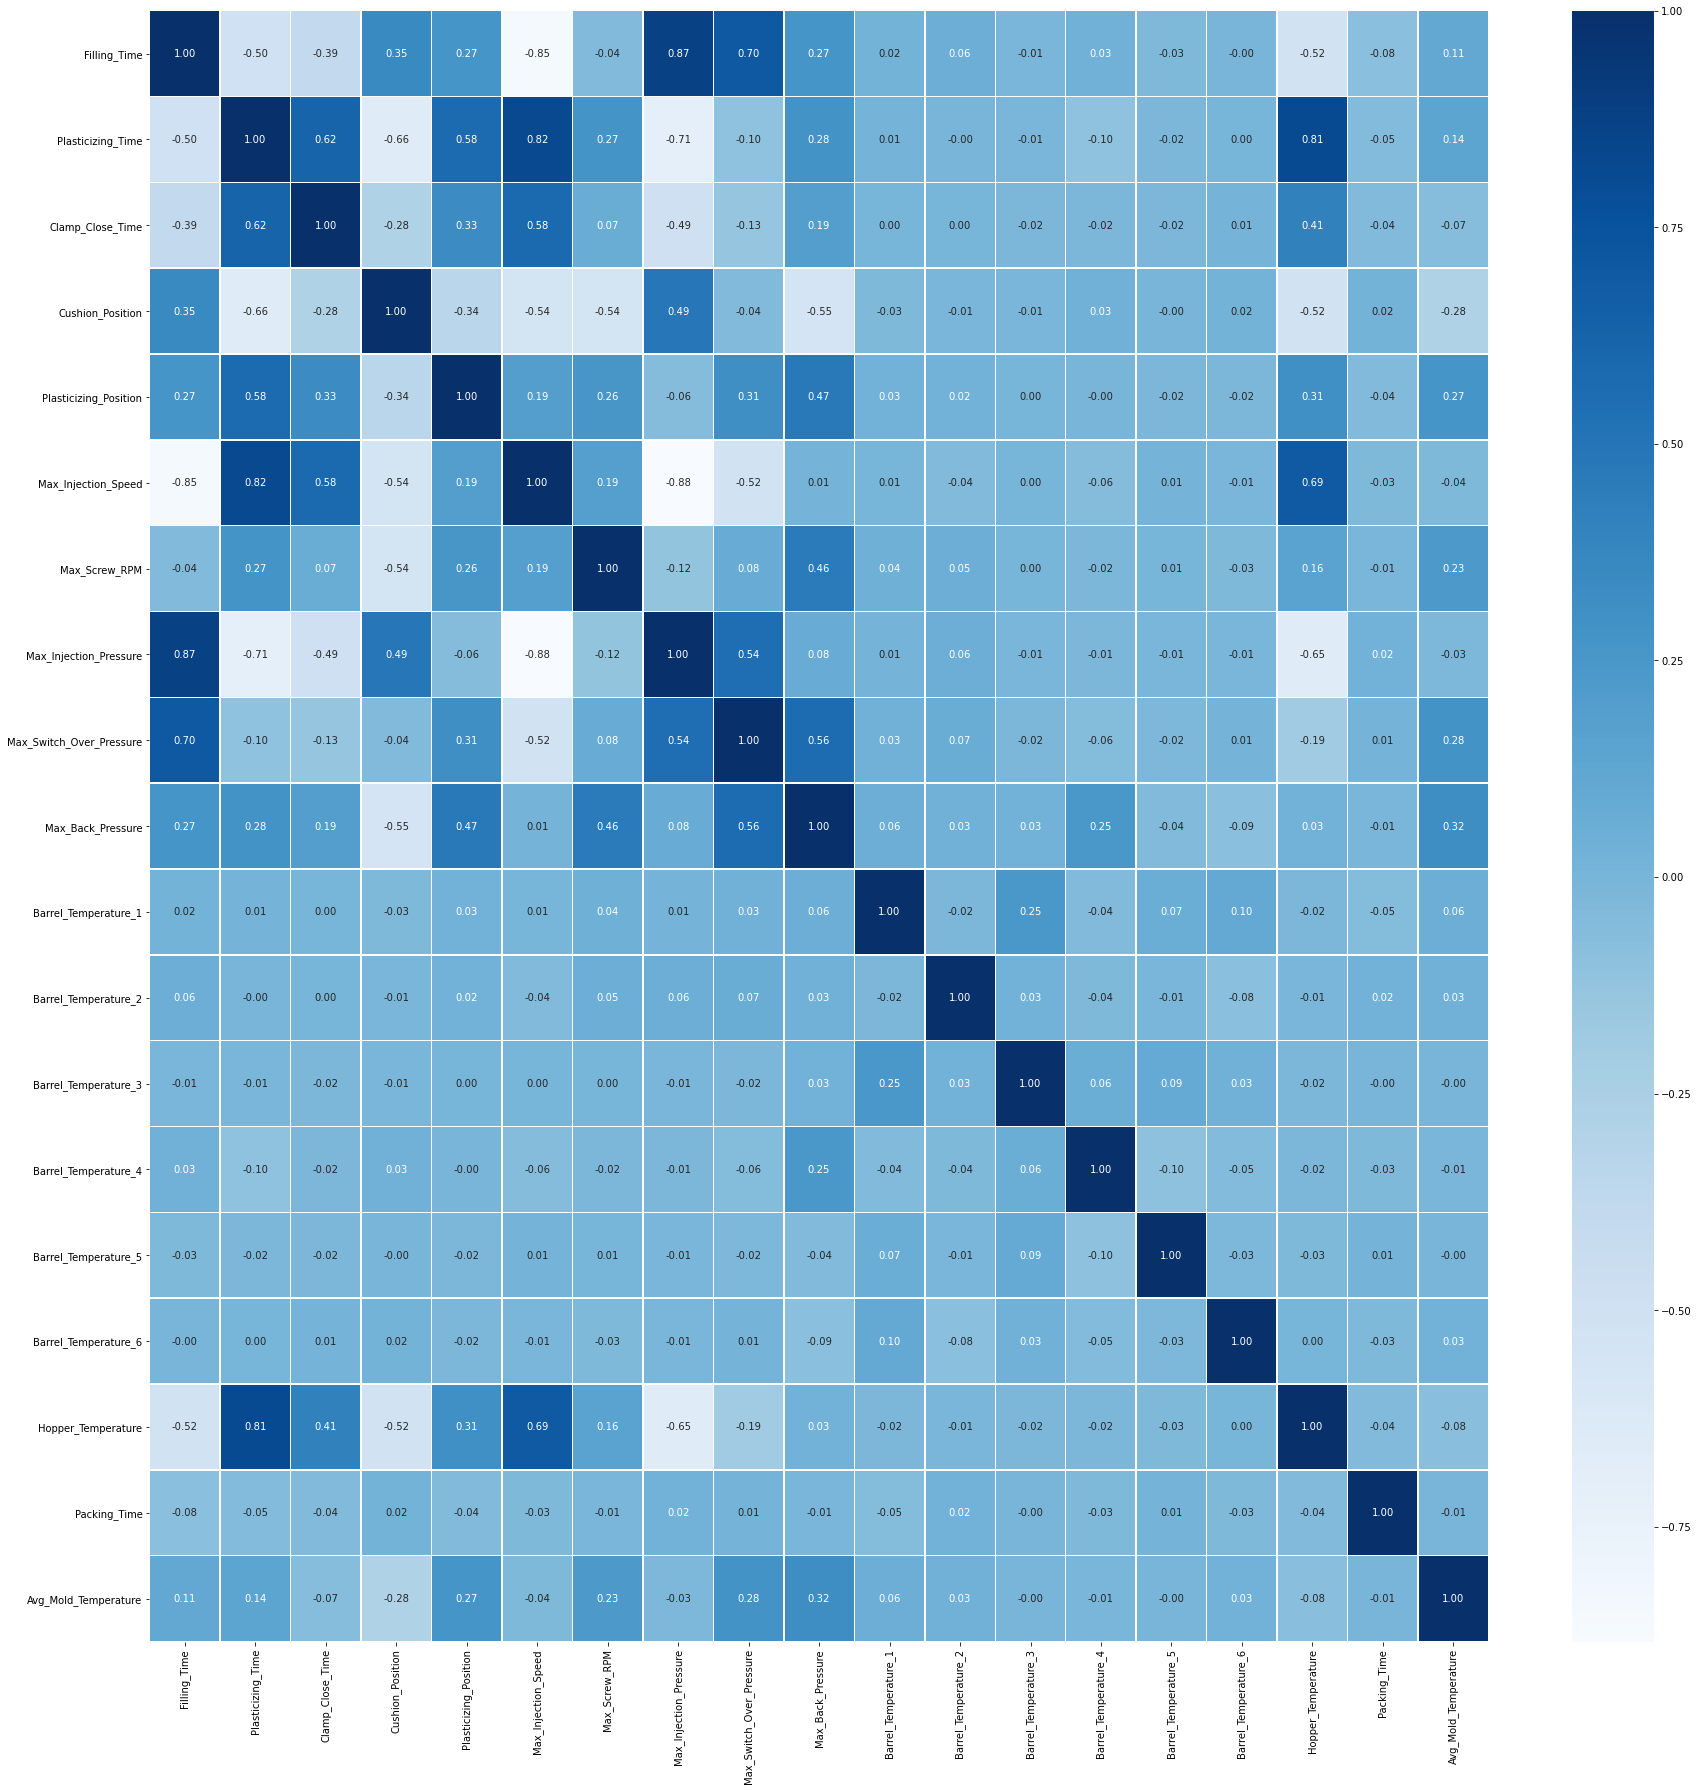

In [146]:
# outlier 제거
outlier_result = Train_DF.apply(outlier)
Train_DF = Train_DF[outlier_result.sum(axis=1) < 1]

data = Train_DF
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 데이터 정규화
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(Train_DF)
Y_N = scaler.transform(Labeled_df_N_test)

# 학습, 평가데이터 분리
X, Y_P = train_test_split(X, train_size=0.8, test_size=0.2)

In [147]:
unsc_train_df = scaler.inverse_transform(Train_DF)

unsc_test_df = scaler.inverse_transform(Y_P)

In [148]:
Train_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6149 entries, 2890 to 10517
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              6149 non-null   float64
 1   Plasticizing_Time         6149 non-null   float64
 2   Clamp_Close_Time          6149 non-null   float64
 3   Cushion_Position          6149 non-null   float64
 4   Plasticizing_Position     6149 non-null   float64
 5   Max_Injection_Speed       6149 non-null   float64
 6   Max_Screw_RPM             6149 non-null   float64
 7   Max_Injection_Pressure    6149 non-null   float64
 8   Max_Switch_Over_Pressure  6149 non-null   float64
 9   Max_Back_Pressure         6149 non-null   float64
 10  Barrel_Temperature_1      6149 non-null   float64
 11  Barrel_Temperature_2      6149 non-null   float64
 12  Barrel_Temperature_3      6149 non-null   float64
 13  Barrel_Temperature_4      6149 non-null   float64
 14  Barr

In [196]:
def denoising_autoencoder(data):
    data_input = Input((data.shape[1],))
    denoising = Dropout(0.6)(data_input)
    h1 = Dense(8)(data_input)
    h1 = BatchNormalization()(h1)
    h1 = Activation('swish')(h1)
    h2 = Dense(4)(h1)
    h2 = BatchNormalization()(h2)
    h2 = Activation('swish')(h2)
    h3 = Dense(2)(h2)
    h3 = BatchNormalization()(h3)
    h3 = Activation('swish')(h3)
    h4 = Dense(4)(h3)
    h4 = BatchNormalization()(h4)
    h4 = Activation('swish')(h4)
    h5 = Dense(8)(h4)
    h5 = BatchNormalization()(h5)
    h5 = Activation('swish')(h5)
    h6 = Dense(data.shape[1])(h5)
    h6 = BatchNormalization()(h6)
    out_put = Activation('sigmoid')(h6)
    
    DAE = Model(data_input, out_put)
    Encoder = Model(data_input, h3)
    
    DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    DAE.summary()
    return DAE, Encoder
#     # Encoder
#     dropout_encoder = Sequential([Dropout(0.3), Dense(10, activation="relu"), Dense(5, activation="relu"), Dense(3, activation="relu")])
#     # Decoder
#     dropout_decoder = Sequential([Dense(5, activation="relu", input_shape=[3]), Dense(10, activation="relu", input_shape=[5]), Dense(data.shape[1], activation="relu")])
#     DAE = Sequential([dropout_encoder, dropout_decoder])
#     DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#     return DAE

In [197]:
# DAE 적용
DAE, Encoder = denoising_autoencoder(X)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 19)]              0         
_________________________________________________________________
dense_68 (Dense)             (None, 8)                 160       
_________________________________________________________________
batch_normalization_44 (Batc (None, 8)                 32        
_________________________________________________________________
activation_60 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 36        
_________________________________________________________________
batch_normalization_45 (Batc (None, 4)                 16        
_________________________________________________________________
activation_61 (Activation)   (None, 4)                 0  

In [198]:
# 모델 훈련
history = DAE.fit(X, X, batch_size=10, epochs=1000, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_loss", patience=10, mode="min")])

# 저장된 가중치 불러오기
# DAE.load_weights(path)
# Encoder.load_weights(path)

Epoch 1/1000
394/394 [==============================] - 3s 3ms/step - loss: 0.0776 - accuracy: 0.1705 - val_loss: 0.0541 - val_accuracy: 0.2988
Epoch 2/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0510 - accuracy: 0.2882 - val_loss: 0.0449 - val_accuracy: 0.3364
Epoch 3/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0416 - accuracy: 0.3601 - val_loss: 0.0392 - val_accuracy: 0.3882
Epoch 4/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0386 - accuracy: 0.3962 - val_loss: 0.0371 - val_accuracy: 0.3984
Epoch 5/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0365 - accuracy: 0.4417 - val_loss: 0.0354 - val_accuracy: 0.4096
Epoch 6/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0351 - accuracy: 0.4493 - val_loss: 0.0336 - val_accuracy: 0.4543
Epoch 7/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0341 - accuracy: 0.4569 - val_loss: 0.0324 - val_accuracy:

394/394 [==============================] - 1s 2ms/step - loss: 0.0256 - accuracy: 0.5006 - val_loss: 0.0219 - val_accuracy: 0.5173
Epoch 58/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0257 - accuracy: 0.4887 - val_loss: 0.0215 - val_accuracy: 0.5152
Epoch 59/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0254 - accuracy: 0.4986 - val_loss: 0.0220 - val_accuracy: 0.5203
Epoch 60/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0258 - accuracy: 0.4940 - val_loss: 0.0218 - val_accuracy: 0.5193
Epoch 61/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0254 - accuracy: 0.5006 - val_loss: 0.0212 - val_accuracy: 0.5234
Epoch 62/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0252 - accuracy: 0.5057 - val_loss: 0.0221 - val_accuracy: 0.5224
Epoch 63/1000
394/394 [==============================] - 1s 2ms/step - loss: 0.0255 - accuracy: 0.4943 - val_loss: 0.0221 - val_accuracy: 0.5183

In [199]:
# 훈련격과 시각화 함수
def training_visualize(model_his):
    sub = plt.subplot(2, 1, 1)
    # 훈련 결과 시각화
    sub.plot(model_his.history["loss"], label="Training Loss")
    sub.plot(model_his.history["val_loss"], label="Validation Loss")
    sub.legend()
    sub = plt.subplot(2, 1, 2)
    sub.plot(model_his.history["accuracy"], label="Training Acc")
    sub.plot(model_his.history["val_accuracy"], label="Validation Acc")
    sub.legend()
    plt.show()

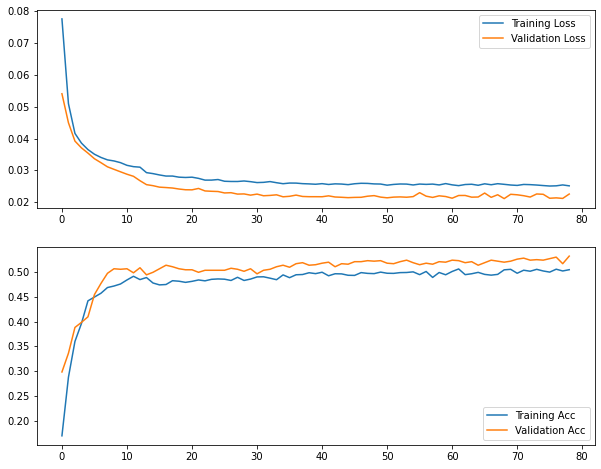

In [200]:
# 데이터 별 훈련결과 시각화
training_visualize(history)

In [201]:
def defective_decision(DAE, train_data, test_data):
    # 학습 데이터 예측값
    pred = DAE.predict(train_data)
    # 학습 데이터 복원 오차
    train_loss = np.mean(np.square(pred-train_data), axis=1)
    #임계치 (3시그마-99.7%)
    threshold = np.mean(train_loss) + 5*np.std(train_loss)

    # 평가 데이터
    # 예측값
    pred_def = DAE.predict(test_data)
    # 복원오차
    test_loss = np.mean(np.square(pred_def - test_data), axis=1)
    
    # colunm별 절대 오차
    colunm_error = np.abs(pred_def - test_data)

    defect = test_loss > threshold
    print("불량 개수: ", np.sum(defect))
    
    return defect, colunm_error

In [202]:
# 확인
print(f"테스트 데이터 개수: {len(Y_P)}")
pos_Y_defect, Y_CE = defective_decision(DAE, X, Y_P)

테스트 데이터 개수: 1230
불량 개수:  0


In [203]:
# 확인
print(f"테스트 데이터 개수: {len(Y_N)}")
neg_N_defect, N_CE = defective_decision(DAE, X, Y_N)

테스트 데이터 개수: 28
불량 개수:  27


In [204]:
true_val = np.concatenate([np.zeros(len(pos_Y_defect)), np.ones(len(neg_N_defect))])
predict_val = np.concatenate([pos_Y_defect, neg_N_defect])

In [205]:
confusion_matrix(true_val, predict_val)

array([[1230,    0],
       [   1,   27]], dtype=int64)

In [206]:
print("정확도: ", accuracy_score(true_val, predict_val))
print("정밀도: ", precision_score(true_val, predict_val))
print("재현율: ", recall_score(true_val, predict_val))
print("F1: ", f1_score(true_val, predict_val))

정확도:  0.9992050874403816
정밀도:  1.0
재현율:  0.9642857142857143
F1:  0.9818181818181818


# (latent_vector 시각화)

C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Attempting to set identical left == right == -0.0 results in singular transformations; automatically expanding.


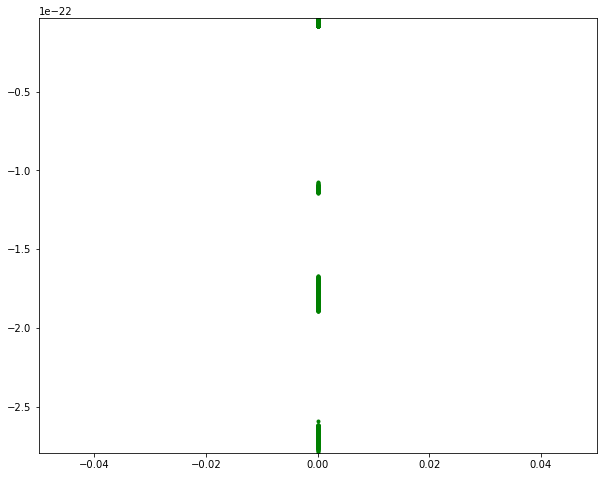

In [208]:
# Pass or Fail, Reason 데이터를 더미 변수로 변환
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()

onehot_PorF = label_encoder.fit_transform(Labeled_CN7_650T_train["PassOrFail"])
Labeled_CN7_650T_train["PassOrFail"] = onehot_PorF

Y_vis3D = Labeled_CN7_650T_train["PassOrFail"]
X_vis3D = scaler.transform(X)

latent_vector = Encoder.predict(X_vis3D)
latent_vector.astype(float)

# tsne = TSNE(n_components=3, verbose=1, n_iter=300, perplexity=5)
# tsne_v = tsne.fit_transform(latent_vector)

rcParams['figure.figsize'] = 10, 8
fig = plt.figure(1)
ax = fig.add_subplot(111)
# ax = Axes3D(fig)

xs = latent_vector[:, 0]
ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# xs = tsne_v[:, 0]
# ys = tsne_v[:, 1]
# zs = tsne_v[:, 2]

# color = ['red', 'green', 'blue', 'lime', 'white', 'pink', 'aqua', 'violet', 'gold', 'coral']
color = ['red', 'green']

for x, y, z, label in zip(xs, ys, zs, Y_vis3D):
  c=color[int(label)]
  ax.plot(x,y,linestyle="none", marker=".", mec=c, mfc=c)
#   ax.text(x,y,z,label, backgroundcolor=c)

ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
# ax.set_zlim(zs.min(), zs.max())

plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 4919 samples in 0.008s...
[t-SNE] Computed neighbors for 4919 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4919
[t-SNE] Computed conditional probabilities for sample 2000 / 4919
[t-SNE] Computed conditional probabilities for sample 3000 / 4919
[t-SNE] Computed conditional probabilities for sample 4000 / 4919
[t-SNE] Computed conditional probabilities for sample 4919 / 4919
[t-SNE] Mean sigma: 0.025726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.048622
[t-SNE] KL divergence after 300 iterations: 2.522341


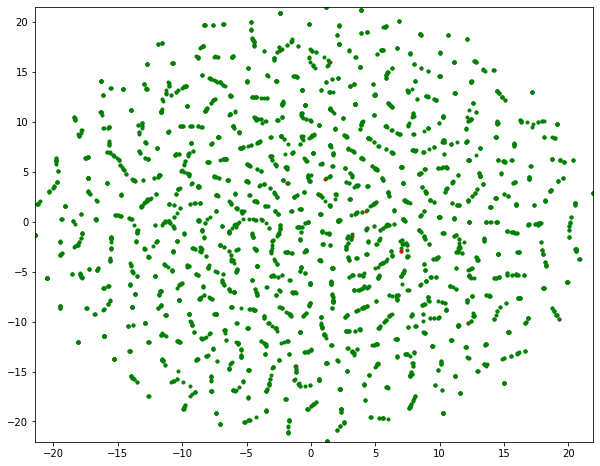

In [161]:
# Pass or Fail, Reason 데이터를 더미 변수로 변환
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()

onehot_PorF = label_encoder.fit_transform(Labeled_CN7_650T_train["PassOrFail"])
Labeled_CN7_650T_train["PassOrFail"] = onehot_PorF

Y_vis2D = Labeled_CN7_650T_train["PassOrFail"]
X_vis2D = scaler.transform(X)

latent_vector = Encoder.predict(X_vis2D)
latent_vector.astype(float)

tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5)
tsne_v = tsne.fit_transform(latent_vector)

fig = plt.figure()
ax = fig.add_subplot(111)

xs = tsne_v[:, 0]
ys = tsne_v[:, 1]

# color = ['red', 'green', 'blue', 'lime', 'white', 'pink', 'aqua', 'violet', 'gold', 'coral']
color = ['red', 'green']

for x, y, label in zip(xs, ys, Y_vis2D):
  c=color[int(label)]
  ax.plot(x,y,linestyle="none", marker=".", mec=c, mfc=c)

ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())

plt.show()

In [163]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

# data = useless_drop_unlabeled_df[useless_drop_unlabeled_df["Switch_Over_Position"] != 0]
# for index, value in enumerate(data):
#     sub = plt.subplot(6, 5, index+1)
#     sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
#     plt.title(value)

# 비선형 regression

In [164]:
xlist=[unsc_test_df[:,0],unsc_test_df[:,1],unsc_test_df[:,2],unsc_test_df[:,3],
       unsc_test_df[:,4],unsc_test_df[:,5],unsc_test_df[:,6],unsc_test_df[:,7],
      unsc_test_df[:,8],unsc_test_df[:,9],unsc_test_df[:,10],unsc_test_df[:,1],
      unsc_test_df[:,12], unsc_test_df[:,13], unsc_test_df[:,14], unsc_test_df[:,15],unsc_test_df[:,16],unsc_test_df[:,17],unsc_test_df[:,18]]
elist=[Y_CE[:,0],Y_CE[:,1],Y_CE[:,2],Y_CE[:,3],Y_CE[:,4],Y_CE[:,5],Y_CE[:,6],
      Y_CE[:,7],Y_CE[:,8],Y_CE[:,9],Y_CE[:,10],Y_CE[:,11],Y_CE[:,12],Y_CE[:,13],Y_CE[:,14],Y_CE[:,15],Y_CE[:,16],Y_CE[:,17],Y_CE[:,18]]

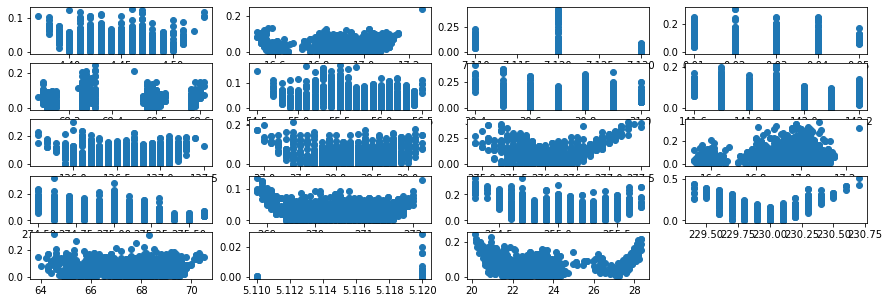

In [165]:
fig = plt.figure(figsize=(15, 5))

def scatter():
    i=0
    while i < 19:
        plt.subplot(5,4,i+1)
        plt.scatter(xlist[i],elist[i])
        i=i+1
    return
scatter()

In [166]:
def reg():
    i=0
    global reg_list
    reg_list=[]
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    while i < 19:
        x=xlist[i].reshape(-1,1)
        y=elist[i].reshape(-1,1)
        x_poly = poly_features.fit_transform(x)
        #print(x[0], x_poly[0])
        reg_list.append(x[0])
        i=i+1
    return reg_list

reg()

[array([4.41]),
 array([16.95]),
 array([7.13]),
 array([653.42]),
 array([68.47]),
 array([56.2]),
 array([30.7]),
 array([141.8]),
 array([136.1]),
 array([38.2]),
 array([275.9]),
 array([16.95]),
 array([275.1]),
 array([271.2]),
 array([255.2]),
 array([230.1]),
 array([68.4]),
 array([5.12]),
 array([20.6])]

<Figure size 1080x360 with 0 Axes>

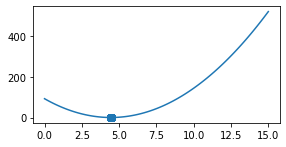

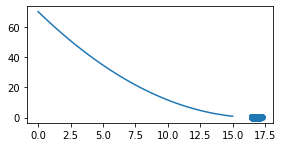

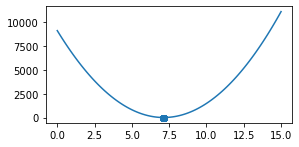

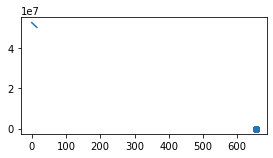

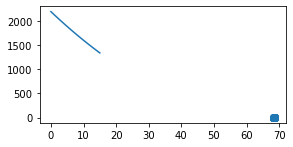

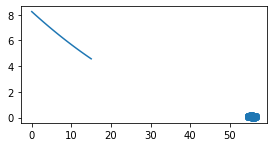

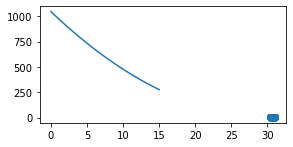

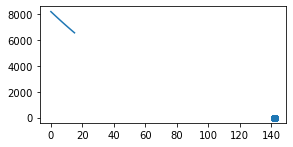

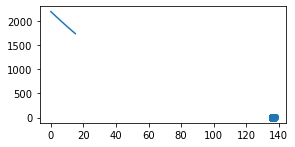

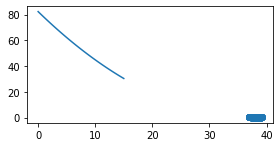

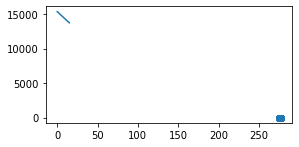

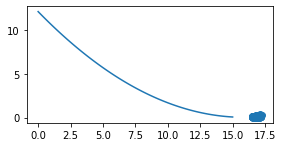

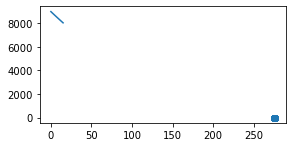

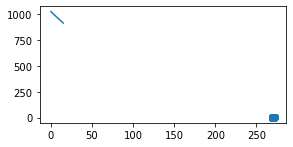

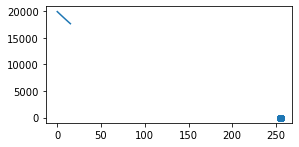

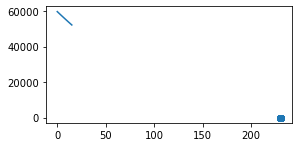

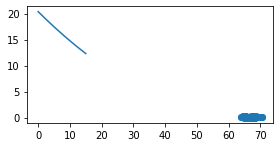

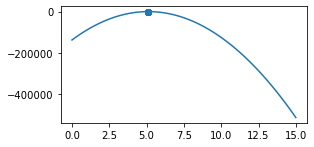

In [167]:
# 다항회귀 그래프
def reg_plt():
    i=0
    fig = plt.figure(figsize=(15, 5))
    model_lr = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                         LinearRegression())
    while i < 18:
        x=xlist[i].reshape(-1,1)
        y=elist[i].reshape(-1,1)
        xx = np.linspace(0, 15,100)
        model_lr.fit(x, y)
        #print(model_lr.steps[1][1].coef_) 
        y_pred = model_lr.predict(xx[:, np.newaxis])
        fig = plt.figure(figsize=(15, 15))
        plt.subplot(6,3,i+1)
        plt.plot(xx, y_pred)
        plt.scatter(x,y)
        i=i+1
    return
reg_plt()

#간단한 딥러닝 예측

In [209]:
model = Sequential([Dense(20, input_dim = 1 ,activation='swish'),Dense(20, activation='swish'),Dense(20, activation='swish'),Dense(1)])
model.compile(loss='mean_squared_error', optimizer='adam')
x = unsc_test_df[:,4]
y = Y_CE[:,4]
history = model.fit(x,y, epochs=500, verbose=2)

Epoch 1/500
39/39 - 0s - loss: 1.8125
Epoch 2/500
39/39 - 0s - loss: 0.0186
Epoch 3/500
39/39 - 0s - loss: 0.0100
Epoch 4/500
39/39 - 0s - loss: 0.0094
Epoch 5/500
39/39 - 0s - loss: 0.0094
Epoch 6/500
39/39 - 0s - loss: 0.0094
Epoch 7/500
39/39 - 0s - loss: 0.0093
Epoch 8/500
39/39 - 0s - loss: 0.0097
Epoch 9/500
39/39 - 0s - loss: 0.0100
Epoch 10/500
39/39 - 0s - loss: 0.0096
Epoch 11/500
39/39 - 0s - loss: 0.0103
Epoch 12/500
39/39 - 0s - loss: 0.0096
Epoch 13/500
39/39 - 0s - loss: 0.0096
Epoch 14/500
39/39 - 0s - loss: 0.0094
Epoch 15/500
39/39 - 0s - loss: 0.0095
Epoch 16/500
39/39 - 0s - loss: 0.0096
Epoch 17/500
39/39 - 0s - loss: 0.0093
Epoch 18/500
39/39 - 0s - loss: 0.0095
Epoch 19/500
39/39 - 0s - loss: 0.0096
Epoch 20/500
39/39 - 0s - loss: 0.0097
Epoch 21/500
39/39 - 0s - loss: 0.0098
Epoch 22/500
39/39 - 0s - loss: 0.0095
Epoch 23/500
39/39 - 0s - loss: 0.0096
Epoch 24/500
39/39 - 0s - loss: 0.0094
Epoch 25/500
39/39 - 0s - loss: 0.0097
Epoch 26/500
39/39 - 0s - loss: 0.

Epoch 209/500
39/39 - 0s - loss: 0.0100
Epoch 210/500
39/39 - 0s - loss: 0.0098
Epoch 211/500
39/39 - 0s - loss: 0.0105
Epoch 212/500
39/39 - 0s - loss: 0.0107
Epoch 213/500
39/39 - 0s - loss: 0.0097
Epoch 214/500
39/39 - 0s - loss: 0.0099
Epoch 215/500
39/39 - 0s - loss: 0.0097
Epoch 216/500
39/39 - 0s - loss: 0.0105
Epoch 217/500
39/39 - 0s - loss: 0.0100
Epoch 218/500
39/39 - 0s - loss: 0.0108
Epoch 219/500
39/39 - 0s - loss: 0.0104
Epoch 220/500
39/39 - 0s - loss: 0.0098
Epoch 221/500
39/39 - 0s - loss: 0.0097
Epoch 222/500
39/39 - 0s - loss: 0.0099
Epoch 223/500
39/39 - 0s - loss: 0.0103
Epoch 224/500
39/39 - 0s - loss: 0.0101
Epoch 225/500
39/39 - 0s - loss: 0.0101
Epoch 226/500
39/39 - 0s - loss: 0.0098
Epoch 227/500
39/39 - 0s - loss: 0.0097
Epoch 228/500
39/39 - 0s - loss: 0.0107
Epoch 229/500
39/39 - 0s - loss: 0.0104
Epoch 230/500
39/39 - 0s - loss: 0.0096
Epoch 231/500
39/39 - 0s - loss: 0.0105
Epoch 232/500
39/39 - 0s - loss: 0.0098
Epoch 233/500
39/39 - 0s - loss: 0.0097


Epoch 414/500
39/39 - 0s - loss: 0.0092
Epoch 415/500
39/39 - 0s - loss: 0.0092
Epoch 416/500
39/39 - 0s - loss: 0.0092
Epoch 417/500
39/39 - 0s - loss: 0.0092
Epoch 418/500
39/39 - 0s - loss: 0.0093
Epoch 419/500
39/39 - 0s - loss: 0.0093
Epoch 420/500
39/39 - 0s - loss: 0.0093
Epoch 421/500
39/39 - 0s - loss: 0.0092
Epoch 422/500
39/39 - 0s - loss: 0.0092
Epoch 423/500
39/39 - 0s - loss: 0.0092
Epoch 424/500
39/39 - 0s - loss: 0.0092
Epoch 425/500
39/39 - 0s - loss: 0.0092
Epoch 426/500
39/39 - 0s - loss: 0.0092
Epoch 427/500
39/39 - 0s - loss: 0.0092
Epoch 428/500
39/39 - 0s - loss: 0.0092
Epoch 429/500
39/39 - 0s - loss: 0.0092
Epoch 430/500
39/39 - 0s - loss: 0.0093
Epoch 431/500
39/39 - 0s - loss: 0.0092
Epoch 432/500
39/39 - 0s - loss: 0.0092
Epoch 433/500
39/39 - 0s - loss: 0.0092
Epoch 434/500
39/39 - 0s - loss: 0.0093
Epoch 435/500
39/39 - 0s - loss: 0.0093
Epoch 436/500
39/39 - 0s - loss: 0.0092
Epoch 437/500
39/39 - 0s - loss: 0.0092
Epoch 438/500
39/39 - 0s - loss: 0.0092


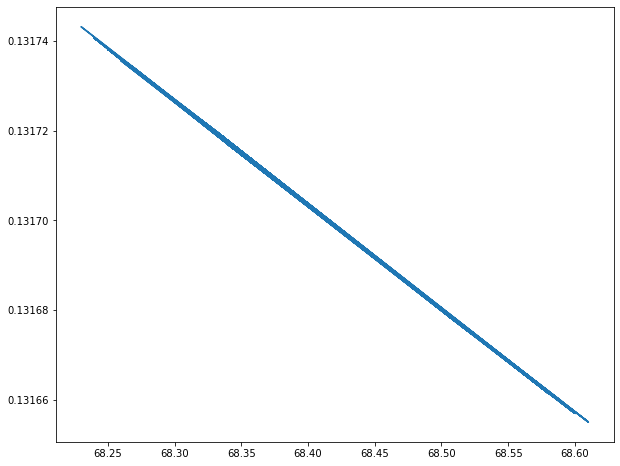

In [210]:
predictions = model.predict(x)
plt.plot(x,predictions)

# 네트워크 가중치 저장

In [172]:
import datetime
dir_name = datetime.datetime.now().strftime(f"%Y%m%d_%H%M_{f1_score(true_val, predict_val):.3f}")
AE_path = fr"./{dir_name}_AE.h5"
DAE.save_weights(AE_path)
E_path = fr"./{dir_name}_E.h5"
Encoder.save_weights(E_path)